In [ ]:
import os
import pandas as pd
import mysql.connector
import numpy as np
import matplotlib as plt
# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sales'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vmateapp1@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/HP/OneDrive/Desktop/E-commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

List all unique cities where customers are located.

In [14]:
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vmateapp1@',
    database='ecommerce'  
)
cursor = db.cursor()
        
query = "select distinct customer_city from customers"
cursor.execute(query)
data = cursor.fetchall()
data
formatted_data = pd.DataFrame(data)
formatted_data

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


Count the number of orders placed in 2017 

In [31]:
query = "select count(order_id) from orders where year(order_purchase_timestamp) = 2017"
cursor.execute(query)
data = cursor.fetchall()
"total order placed in 2017 are :",data[0][0]

('total order placed in 2017 are :', 45101)

Find total sales per category

In [ ]:
query = """ select upper(products.product_category) as category,
round(sum(payments.payment_value),2) as total_sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_icad = order_items.order_id
group by category 
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['category', 'total_sales'])
df

,category,total_sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


calculate the percentage of order that were paid in installment

In [41]:
query = """select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*) *100 
from payments ;
"""
cursor.execute(query)
data = cursor.fetchall()
data

[(Decimal('99.9981'),)]

count the number of customers from each state.

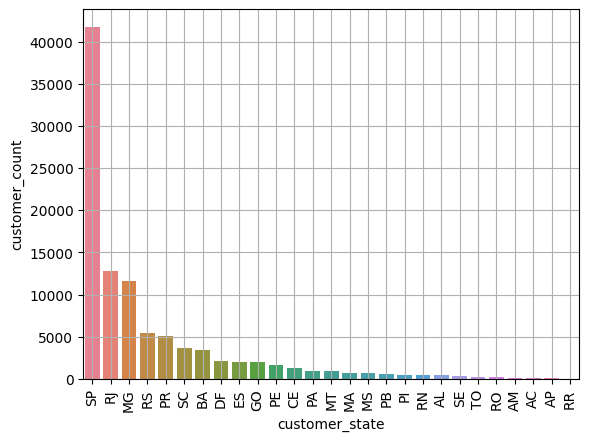

In [59]:

import seaborn as sns
import matplotlib.pyplot as plt
query = """select customer_state,count(customer_id) 
from customers 
group by customer_state;
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=['customer_state','customer_count'])
df = df.sort_values(by='customer_count',ascending=False)
sns.barplot(x=df['customer_state'],y=df['customer_count'],hue = df['customer_state'])
plt.grid()
plt.xticks(rotation=90)
plt.show()

calculate the number of orders per moth in 2018


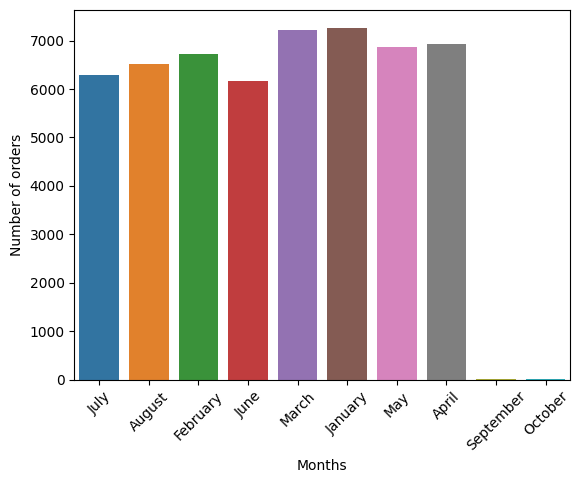

In [80]:
query = """select monthname(order_purchase_timestamp) as month,
count(order_id) as order_count
from orders 
where year(order_purchase_timestamp)=2018
group by month
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=['month','order_count'])
df
sns.barplot(x=df['month'],y=df['order_count'],hue=df['month'])
plt.xticks(rotation= 45)
plt.xlabel('Months')
plt.ylabel('Number of orders')
plt.show()

Find the average number of products per order, grouped by customer city

In [ ]:
query = """with count_per_order as 
(select orders.order_id,orders.customer_id
,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)
select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame (data)
df

,0,1
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00
